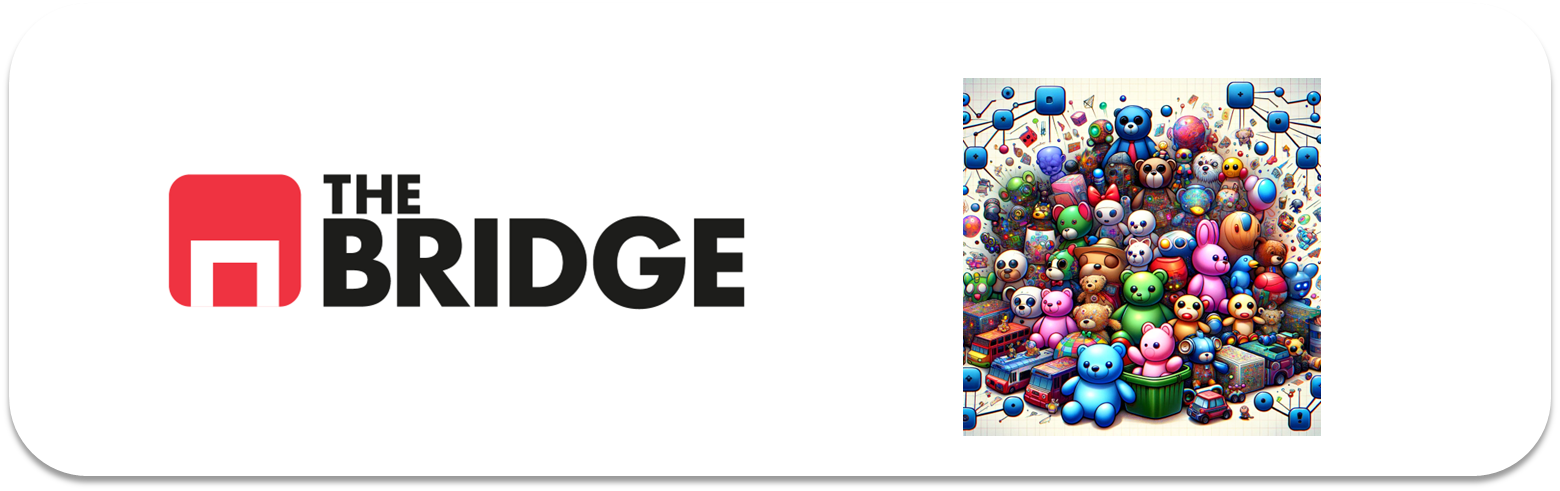

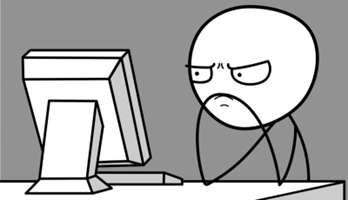

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import combinations
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuáles segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cuál deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar por qué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


1. Entender el problema

*Vamos a emplear DBSCAN porque nos lo piden explícitamente y además un clustering jerárquico porque necesitamos establecer algún tipo de relación entre los clústeres encontrados.*  
*Por otro lado, esperaremos encontrar entre 3 y 5 clústeres pero en el caso de DBSCAN no jugaremos con ese hiperparámetro, y en el del clústering jerárquico lo comprobaremos con el método del máximo gap*

2. Cargar datos, visualizar

In [2]:
train_set = pd.read_csv("./data/empowering_drinks.csv", sep = "|")
train_set

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina
0    1.518613               0.232053  1.034819       1.013009  0.251717
1    0.246290              -0.827996  0.733629       0.965242 -0.293321
2    0.196879               1.109334  1.215533       1.395148  0.269020
3    1.691550               0.487926  1.466525       2.334574  1.186068
4    0.295700               1.840403  0.663351      -0.037874 -0.319276
..        ...                    ...       ...            ...       ...
148  0.493343               0.414820 -1.284344       0.009893  0.969783
149  0.332758              -0.389355 -1.344582       0.280575  2.224236
150  0.209232               0.012732 -1.354622       0.296498  1.834923
151  1.395086               1.365208 -1.274305      -0.595160  1.791666
152  0.019564               0.039106 -1.500000       0.081020  0.500000

[153 rows x 5 columns]

*Los valores tienen pinta de haber sido escalados y preparados ya para trabajar sobre ellos, veamos con un describe*

In [3]:
train_set.describe()

Azúcares  Vitamínas del grupo B     Cafeína  Ácido Cítrico  \
count  153.000000             153.000000  153.000000     153.000000   
mean     0.019231               0.037273    0.041057       0.080022   
std      1.026182               0.995984    1.040928       1.009450   
min     -2.434235              -3.679162   -1.695971      -1.493188   
25%     -0.816038              -0.499016   -1.043392      -0.738463   
50%      0.061000              -0.023821    0.211566      -0.165254   
75%      0.876275               0.707247    0.894264       0.917474   
max      2.259772               3.156325    3.062832       2.971473   

          Taurina  
count  153.000000  
mean    -0.044088  
std      0.934399  
min     -1.634288  
25%     -0.799428  
50%     -0.154899  
75%      0.493956  
max      2.431870

*Efectivamente son medias cercanas a 0 y desviaciones cercanas a 1, con lo que esta parte me la ahorro*

In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


*153 experimentos sin nulos aparentemente, todo variable numéricas*

3. MiniEDA

*La idea es comprobar las relaciones entre las variables para intentar observar alguna posible clusterizacion y así además seleccionar variables y por supuesto comprobar si hay que transformar y escalar (esto normalmente siempre)*  

3.1 *Comprobamos las relaciones dos a dos con un pairplot y con alguna de las funciones de nuestra biblioteca particular*

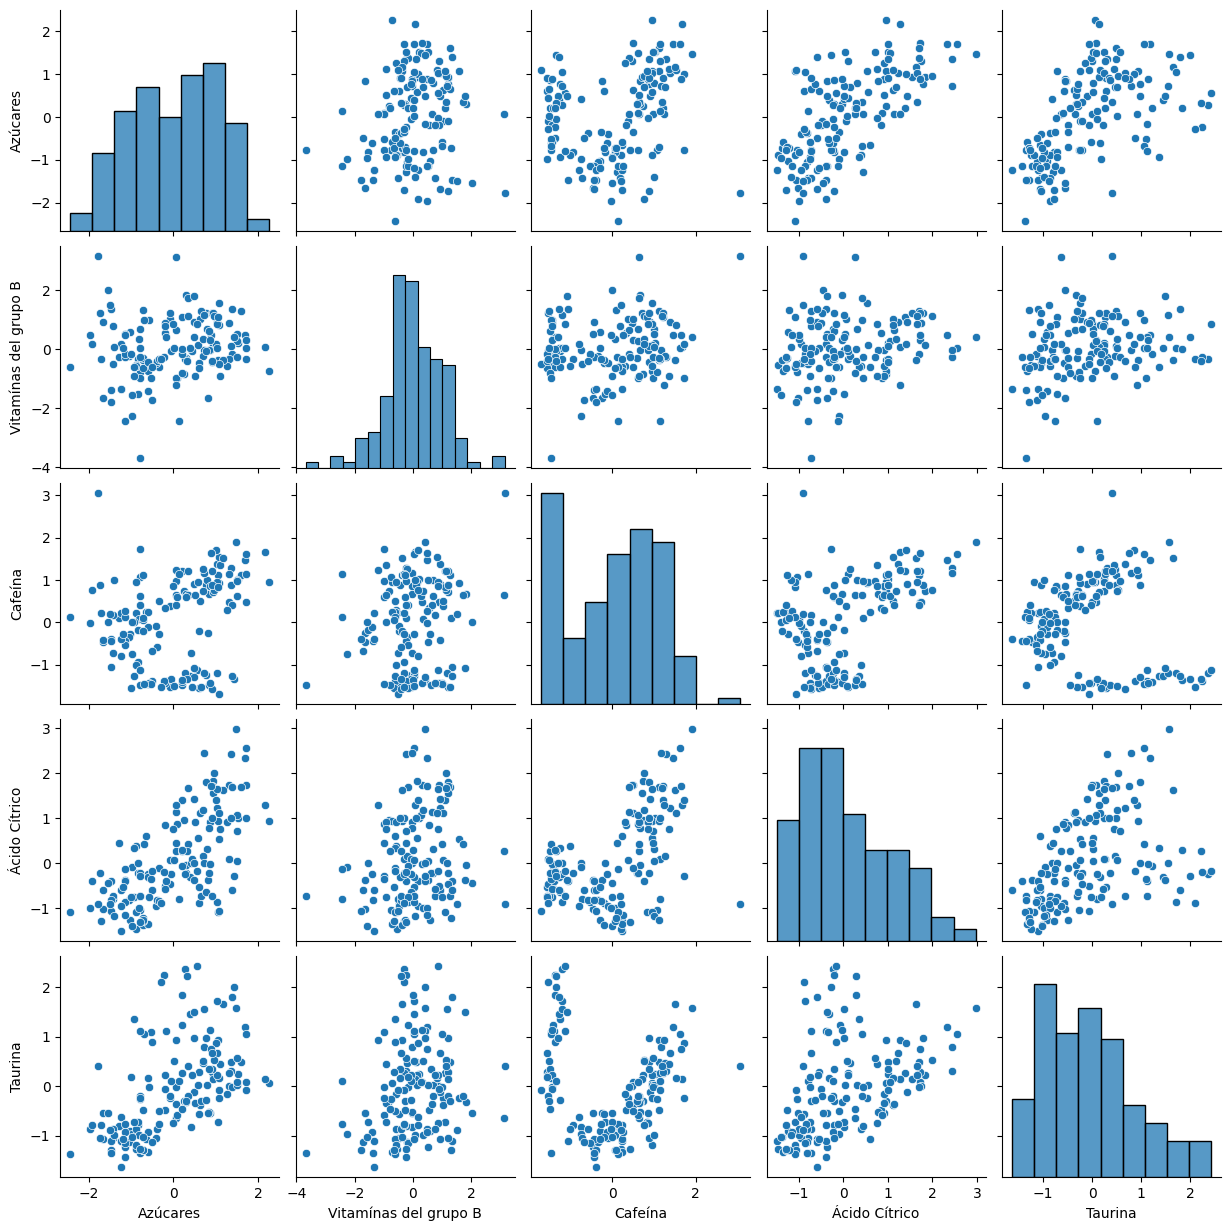

In [5]:
sns.pairplot(train_set)

*Así de primeras es difícil encontrar clusteres tipo mancha (blobs) o radiales separados ente sí que invitaran a un Kmeans, tampoco se ve de primeras otras separaciones, parecen todo brochazos. Por eso no nos queda más remedio que ver gráfico a gráfico o ir directamente a tratar las variables y luego a por los hiperparámetros. Pero esta vez (porque son pocas features) sacaremos los scatter*

In [6]:
for valores in combinations(train_set.columns, r = 2):
    print(valores)

('Azúcares', 'Vitamínas del grupo B')
('Azúcares', 'Cafeína')
('Azúcares', 'Ácido Cítrico')
('Azúcares', 'Taurina')
('Vitamínas del grupo B', 'Cafeína')
('Vitamínas del grupo B', 'Ácido Cítrico')
('Vitamínas del grupo B', 'Taurina')
('Cafeína', 'Ácido Cítrico')
('Cafeína', 'Taurina')
('Ácido Cítrico', 'Taurina')


Azúcares vs Vitamínas del grupo B


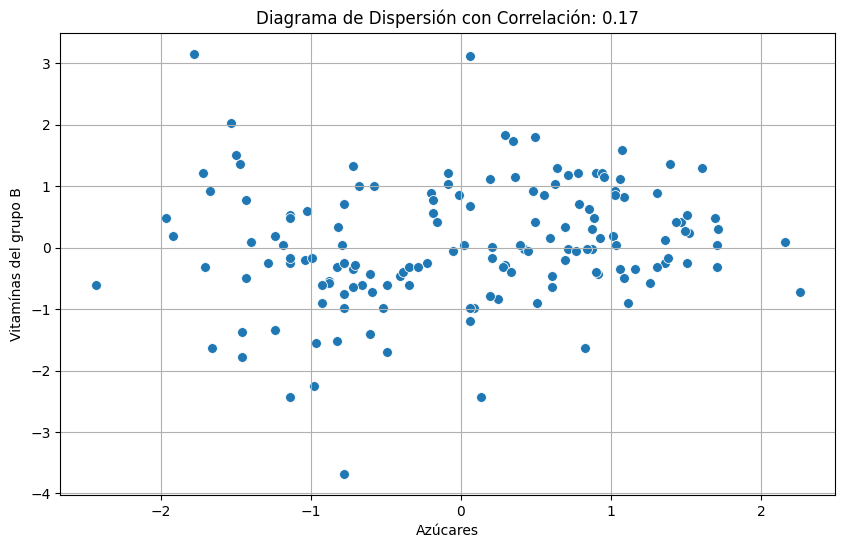

Azúcares vs Cafeína


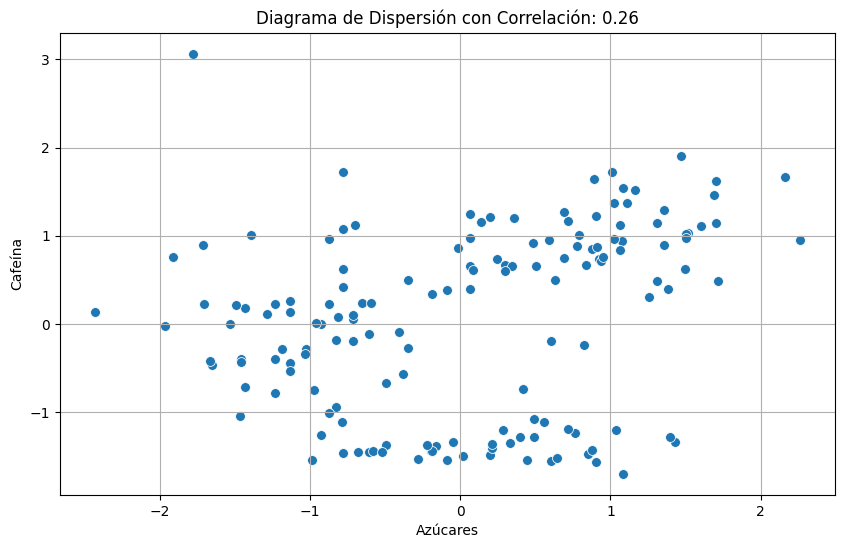

Azúcares vs Ácido Cítrico


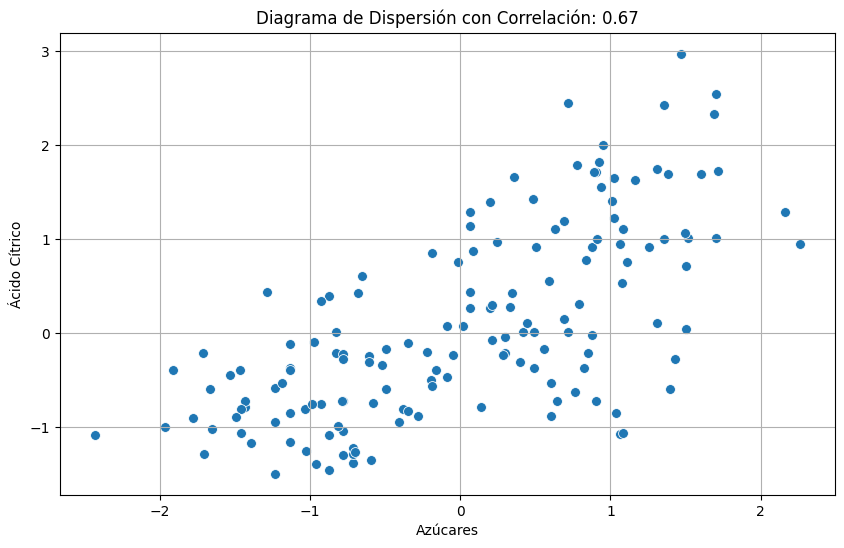

Azúcares vs Taurina


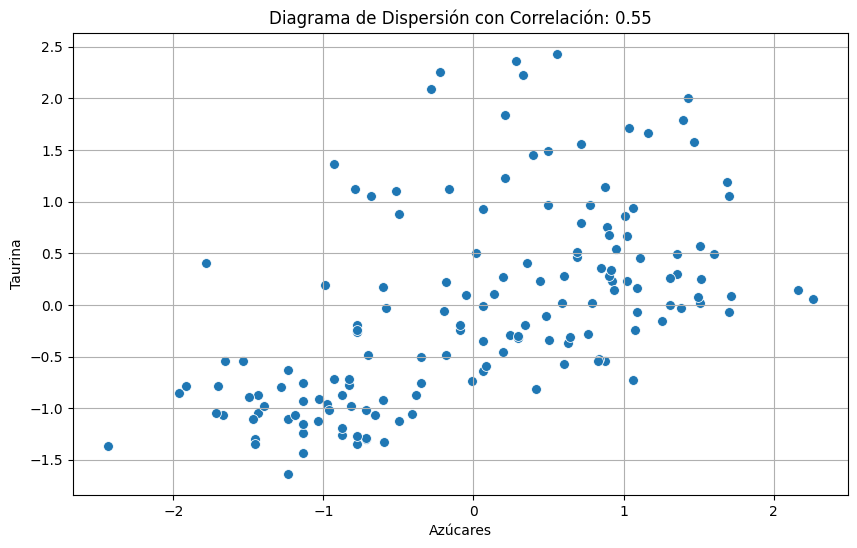

Vitamínas del grupo B vs Cafeína


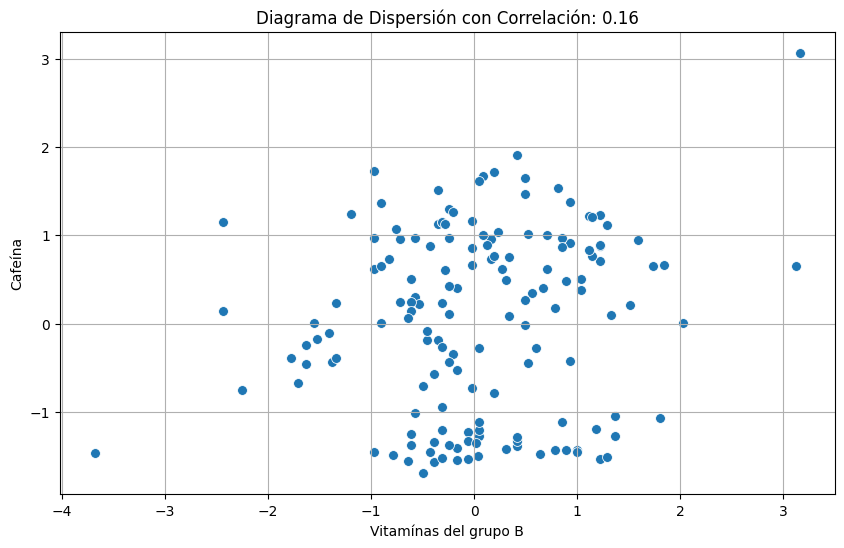

Vitamínas del grupo B vs Ácido Cítrico


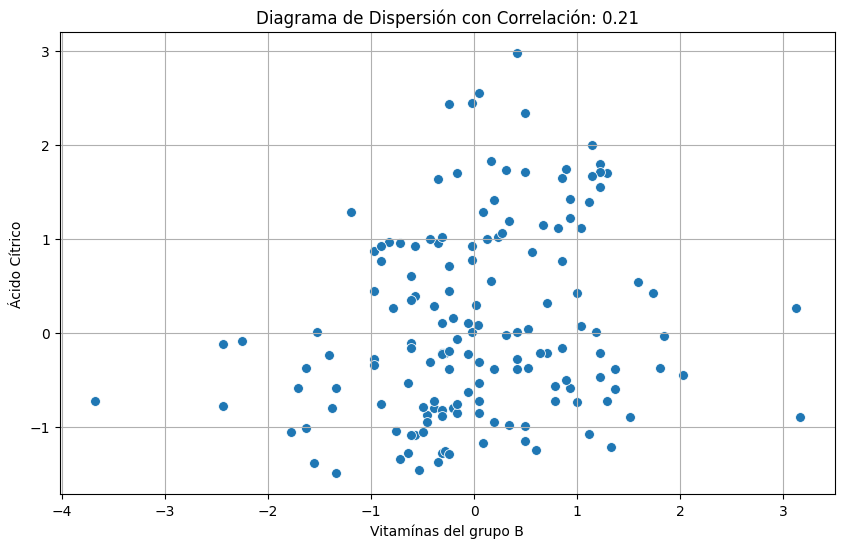

Vitamínas del grupo B vs Taurina


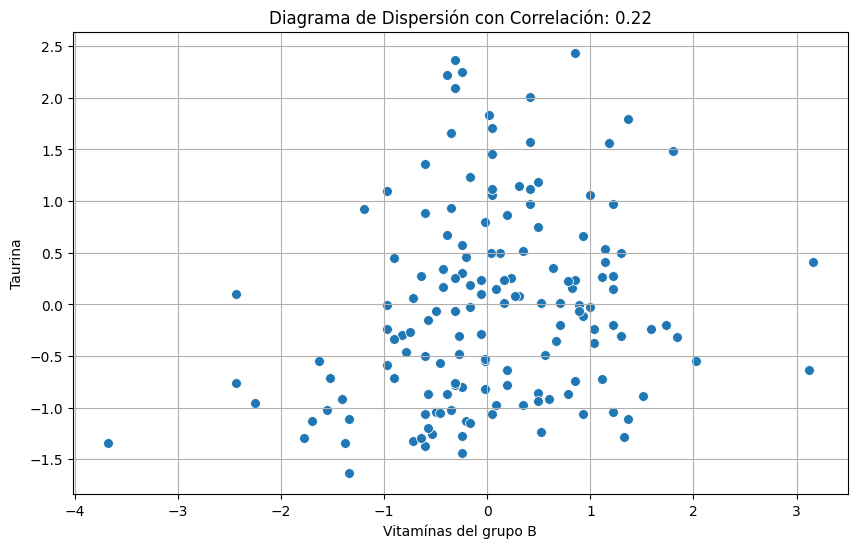

Cafeína vs Ácido Cítrico


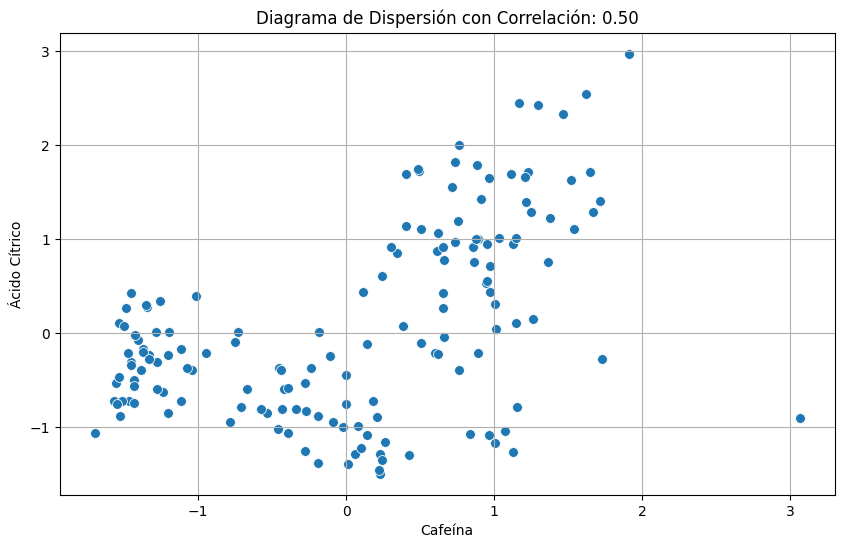

Cafeína vs Taurina


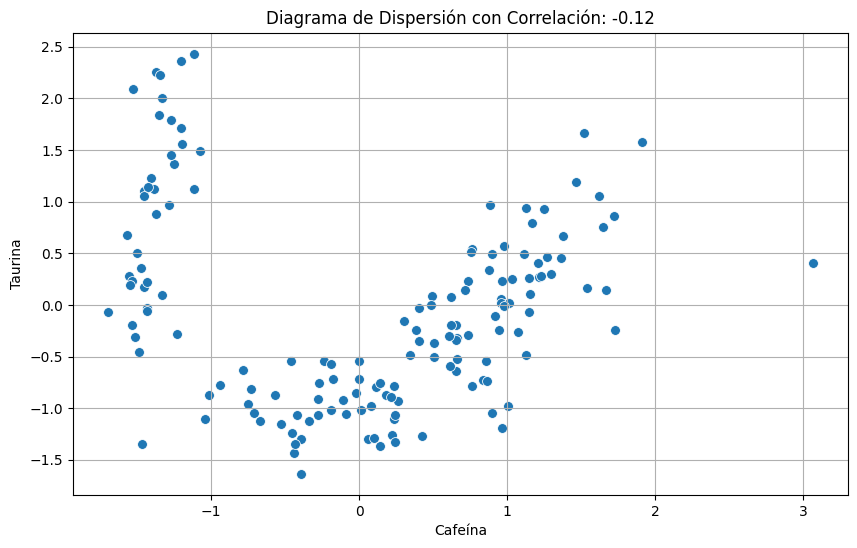

Ácido Cítrico vs Taurina


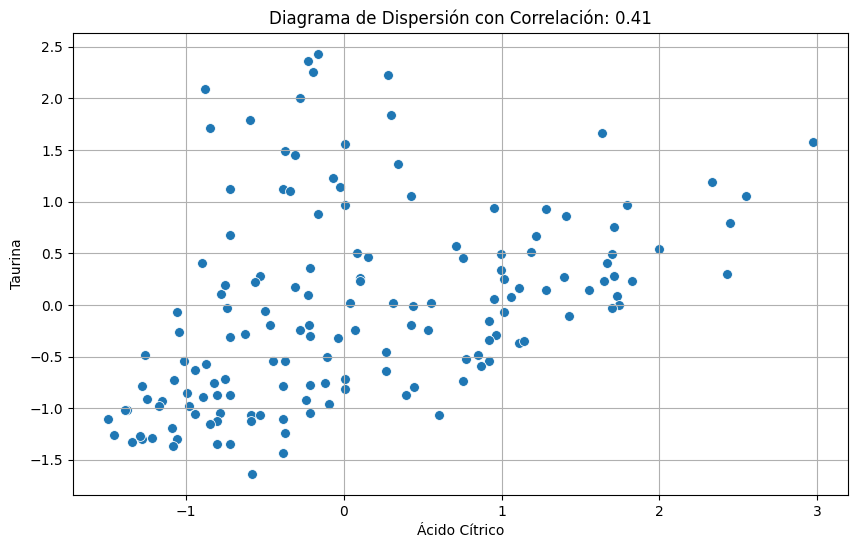

In [7]:
for x, y in combinations(train_set.columns, r = 2):
    print(f"{x} vs {y}")
    bt.grafico_dispersion_con_correlacion(train_set, x, y, mostrar_correlacion = True )

* *Azucares vs Vitaminas B: Brochazo y no se ven formaciones claras*  
* *Azucares vs Cafeína: No es exactamente un brochazo, quizás dos seperaciones una linea superior y otra inferior...Nada concluyente*  
* *Azucares vs Acido citrico: Otro brochazo sencillo, nada concluyente*  
* *Azucares vs Taurina: Similar a la anterior*  
* *Vitaminas B vs Cafeina: Quizás un grupo pequeño a la izquierda, uno superior y un trazo inferior*  
* *Vitaminas B vs Ácido Cítrico: Nada concluyente*  
* *Vitaminas B vs Taurina: Similar al anterior*
* *Cafeina vs Ácido Cítrico: Quizás un cluster a la izquierda, y uno como un trazo o dos en ese trazo diagonal.*  
* *Cafeína vs Taurina: Aquí sí que se ven dos agrupaciones separadas por lo menos a la izquierda en vertical y otra que podrían ser dos aunque tampoco está claro. Pero las dos seperaciones sí. Estas dos variables parecen más interesante*  
* *Ácido Cítrico vs Taurina: Puesto a soñar podría ver tres clusters, pero no se ve nada concluyente*.

*Quizás es un poco "forzado", pero podíamos decir que vemos algo además que podría captar un DBSCAN:*

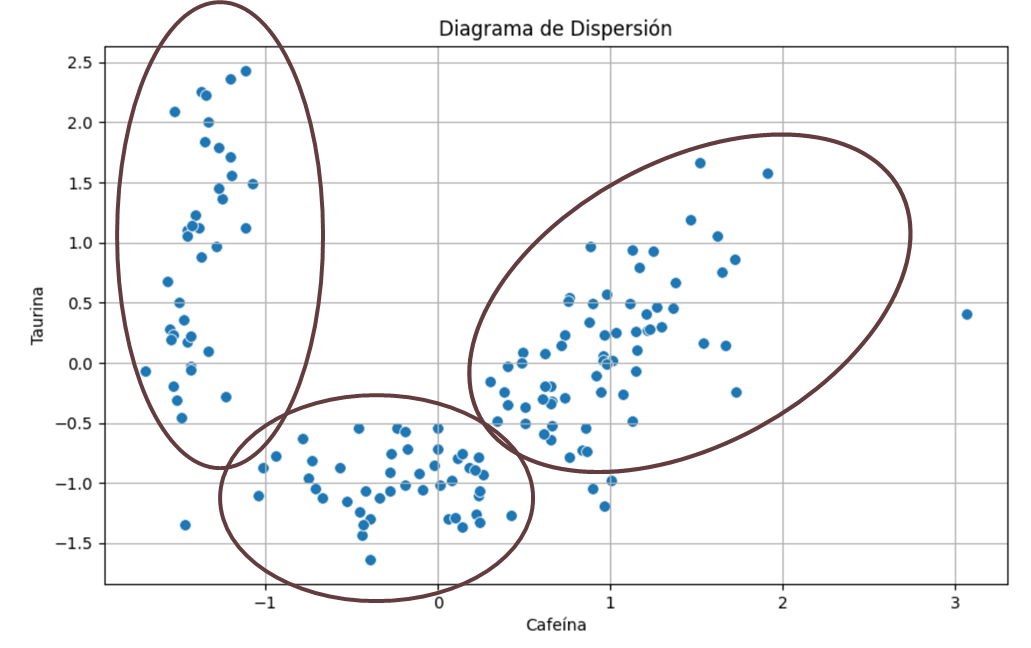

*En esta situación voy a probar dos juegos de features, uno completo y otro sólo con cafeína y taurina (que además tiene pinta de que en temas de energización pintan algo)*

In [8]:
features_short = ["Taurina", "Cafeína"]
features = train_set.columns.to_list()

4. Tratamiento de features

*Tal como se vio en el análisis preliminar las variables parecen tratadas y no hay que tocar el dataset, veamos en cualquier caso para terminar de comprobarlo los histogramas*

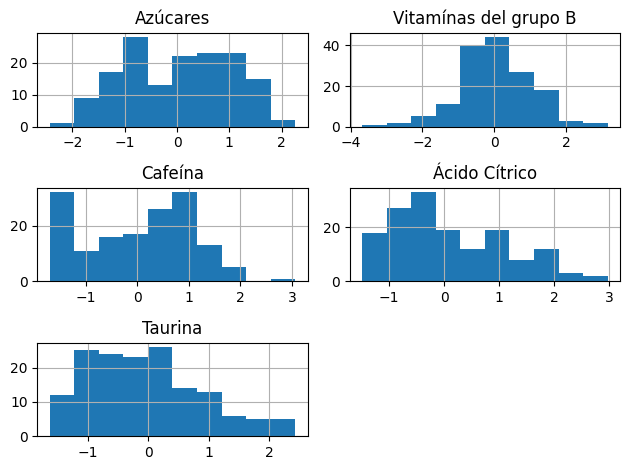

In [9]:
train_set.hist()
plt.tight_layout()

*Quizás podríamos transformar alguna pero dado que los valores ya están prácticamente escalados (ver el describe de arriba), no tocamos más*

5. Ajuste de hiperparámetros (selección de eps, min_samples y de número de clusters para el jerárquico)

**DBSCAN**

En este caso aplicamos lo que vimos en los ejercicios: iterar sobre rangos de estos dos hiperparámetros midiendo el porcentaje de "anomalías" que detecta y considerando como punto de parada un valor por debajo del 10%.

*Para el juego completo de features*

*Es importante fijarnos en la escala y en el numero de puntos que existen (153), considerando como punto de partida el scatter Cafeína-Taurina, poner min_samples > 10 no parece tener mucho sentido por el relativamente pequeño número de puntos que hay, así que vamos a probar con 3, 5 y 10 puntos para considerar un vecindario como un vecindario de instancia core*

In [10]:
outlier_percent = []
experiments = {}
for min_samples in [3, 5, 10]:
    print(f"Min_samples = {min_samples}")
    outlier_percent = []
    for eps in np.linspace(0.001, 6, 100): # Genera 100 valores equidistantes entre 0.001 y 6
        
        # Creamos el modelo
        dbscan = DBSCAN(eps = eps, min_samples = min_samples) # min_samples dos veces el numero de features -> 2 por dimensión del hiperespacio en el que representamos el conjunto de puntos... No le des muchas vueltas es un número muy orientativo. Pero piensa que si fuera un recta querrías 2 valores, un plano 4, un cubo 6...
        dbscan.fit(train_set)

        # Registramos el porcentaje de anomalías (recuerda que se etiquetan como -1)
        perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
        
        #if perc_outliers <= 10:
        #    print(perc_outliers, dbscan.labels_)
        #    print(len(dbscan.labels_))
        #    print(pd.Series(dbscan.labels_).value_counts())
        outlier_percent.append(perc_outliers)
    experiments[min_samples] = outlier_percent.copy()

Min_samples = 3
Min_samples = 5
Min_samples = 10


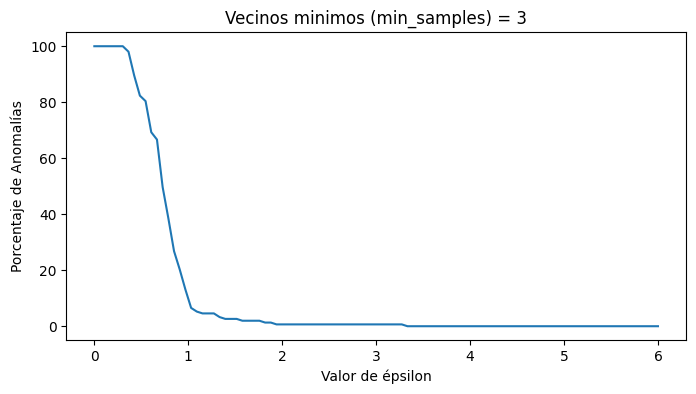

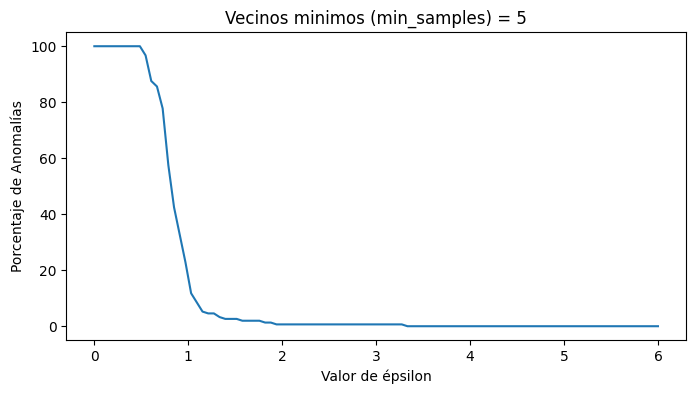

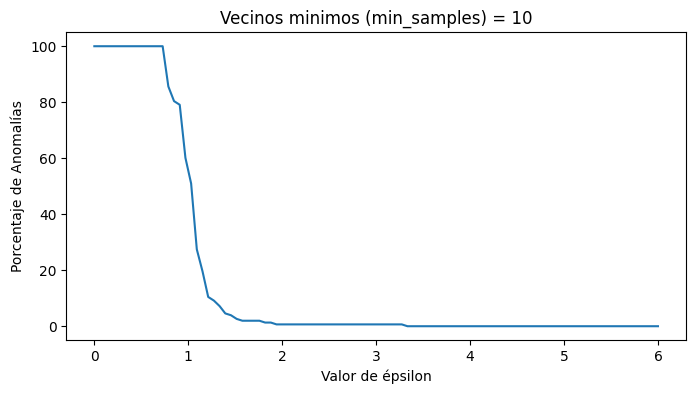

In [11]:
for min_samples in [3, 5, 10]:
    #Vamos a pintar ahora el porcentaje de anomalías vs el valor de eps probado
    plt.figure(figsize = (8, 4), dpi = 100)
    sns.lineplot(x=np.linspace(0.001, 6, 100), y = experiments[min_samples])
    plt.ylabel("Porcentaje de Anomalías")
    plt.xlabel("Valor de épsilon")
    plt.title(f"Vecinos minimos (min_samples) = {min_samples}")
    plt.show()

Entre 1.2 y 2 podríamos situar la `eps` que nos reduce las anomalías a menos de un 10%. Comprobemos:

In [12]:
for min_samples in [3, 5, 10]:
    print(f"Para num_samples = {min_samples}:")
    for indice, valor in enumerate(np.linspace(0.001, 6, 100)):
        if 1.2 <= valor <= 2: # valor es el epsilon
            print(f"{valor} -> {experiments[min_samples][indice]}")

Para num_samples = 3:
1.2129191919191917 -> 4.57516339869281
1.2735151515151513 -> 4.57516339869281
1.334111111111111 -> 3.2679738562091503
1.3947070707070706 -> 2.6143790849673203
1.45530303030303 -> 2.6143790849673203
1.5158989898989896 -> 2.6143790849673203
1.5764949494949492 -> 1.9607843137254901
1.637090909090909 -> 1.9607843137254901
1.6976868686868685 -> 1.9607843137254901
1.758282828282828 -> 1.9607843137254901
1.8188787878787878 -> 1.3071895424836601
1.8794747474747473 -> 1.3071895424836601
1.9400707070707068 -> 0.6535947712418301
Para num_samples = 5:
1.2129191919191917 -> 4.57516339869281
1.2735151515151513 -> 4.57516339869281
1.334111111111111 -> 3.2679738562091503
1.3947070707070706 -> 2.6143790849673203
1.45530303030303 -> 2.6143790849673203
1.5158989898989896 -> 2.6143790849673203
1.5764949494949492 -> 1.9607843137254901
1.637090909090909 -> 1.9607843137254901
1.6976868686868685 -> 1.9607843137254901
1.758282828282828 -> 1.9607843137254901
1.8188787878787878 -> 1.3071895

*Para asegurarnos nos quedamos con eps = 1.3 para los tres rangos de min_samples (anomalías por debajo de un 10%). Vamos a ver ahora cuántos clusters se forman para esos valores de hiperparámetros y si están entre 3 y 5 que son los que nos sugirieron los químicos*

In [13]:
for min_samples in [3, 5, 10]:
    dbscan = DBSCAN(eps = 1.3, min_samples = min_samples)
    dbscan.fit(train_set)
    print(f"Para {min_samples} de vecinos: {pd.Series(dbscan.labels_).nunique() - 1} clusters")

Para 3 de vecinos: 1 clusters
Para 5 de vecinos: 1 clusters
Para 10 de vecinos: 1 clusters


*No distingue clústeres, para aumentar el número lo mejor es reducir el eps, probemos con 1.2 que todavía daba % de anomalías bajos*

In [14]:
for min_samples in [3, 5, 10]:
    dbscan = DBSCAN(eps = 1.2, min_samples = min_samples)
    dbscan.fit(train_set[["Taurina","Cafeína"]])
    print(f"Para {min_samples} de vecinos: {pd.Series(dbscan.labels_).nunique() - 1} clusters")

Para 3 de vecinos: 1 clusters
Para 5 de vecinos: 1 clusters
Para 10 de vecinos: 1 clusters


Bajamos eps hasta conseguir varios clusters

In [15]:
for min_samples in [3, 5, 10]:
    dbscan = DBSCAN(eps = 0.5, min_samples = min_samples)
    dbscan.fit(train_set[["Taurina","Cafeína"]])
    print(f"Para {min_samples} de vecinos: {pd.Series(dbscan.labels_).nunique() - 1} clusters")

Para 3 de vecinos: 2 clusters
Para 5 de vecinos: 2 clusters
Para 10 de vecinos: 2 clusters


In [16]:
train_set_all = train_set.copy()
train_set_all["Cluster"] = dbscan.labels_

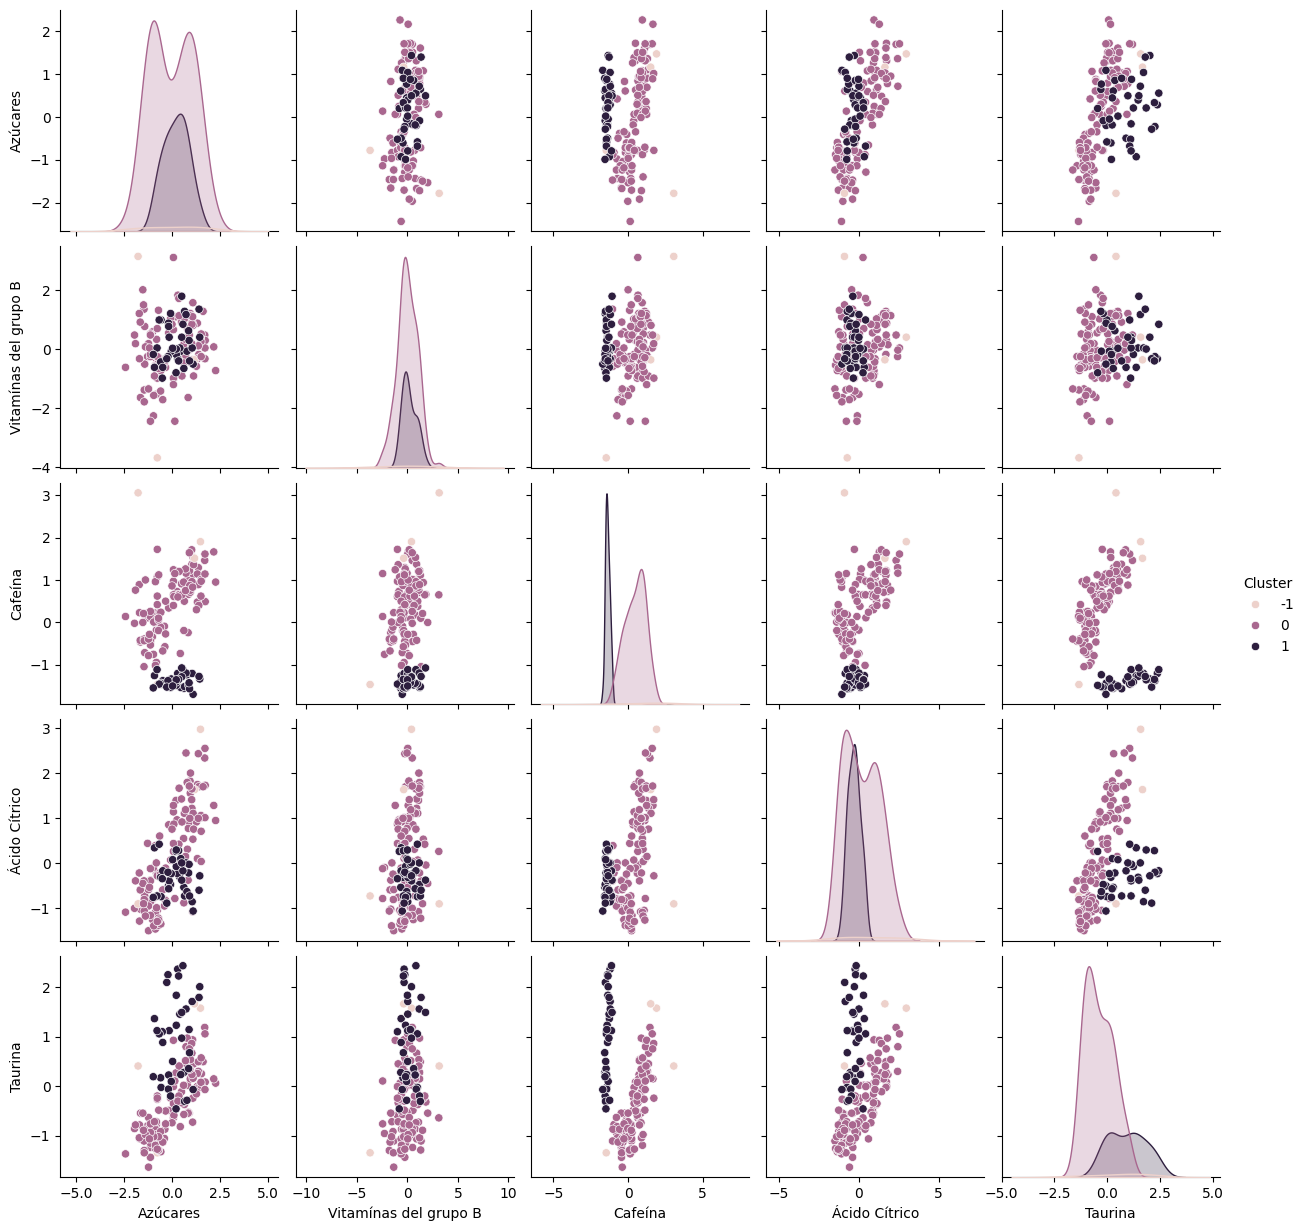

In [17]:
sns.pairplot(train_set_all, hue = "Cluster")

<Axes: xlabel='Cafeína', ylabel='Taurina'>

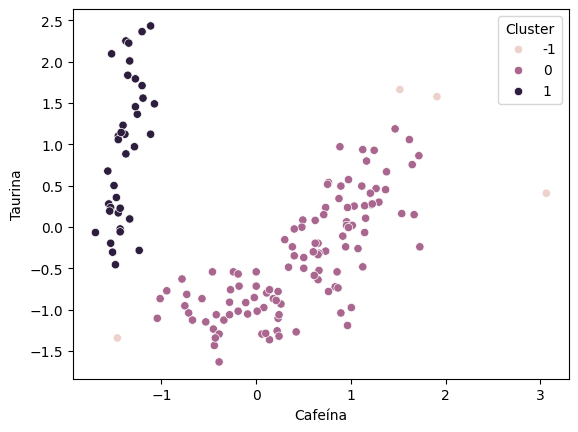

In [18]:
sns.scatterplot(data = train_set_all[["Cafeína", "Taurina", "Cluster"]], x = "Cafeína", y = "Taurina", hue = "Cluster")

*En general, no se puede interpretar demasiado bien en ninguna, salvo en Cafeína-Taurina y Cafeína-Azucares donde se parece al clustering que habíamos intuido. Pero probemos con menos features*

*Este es un caso en el que probablemente demasiadas features engañen al modelo, vamos a probar con nuestras dos features que parecían más prometedoras:*

In [19]:
outlier_percent = []
experiments = {}
for min_samples in [3, 5, 10]:
    print(f"Min_samples = {min_samples}")
    outlier_percent = []
    for eps in np.linspace(0.001, 6, 100): # Genera 50 valores equidistantes entre 0.001 y 3
        
        # Creamos el modelo
        dbscan = DBSCAN(eps = eps, min_samples = min_samples) # min_samples dos veces el numero de features -> 2 por dimensión del hiperespacio en el que representamos el conjunto de puntos... No le des muchas vueltas es un número muy orientativo. Pero piensa que si fuera un recta querrías 2 valores, un plano 4, un cubo 6...
        dbscan.fit(train_set[features_short])

        # Registramos el porcentaje de anomalías (recuerda que se etiquetan como -1)
        perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)

        #if perc_outliers <= 10:
        #    print(perc_outliers, dbscan.labels_)
        #    print(len(dbscan.labels_))
        #    print(pd.Series(dbscan.labels_).value_counts())
        
        outlier_percent.append(perc_outliers)
    experiments[min_samples] = outlier_percent.copy()

Min_samples = 3
Min_samples = 5
Min_samples = 10


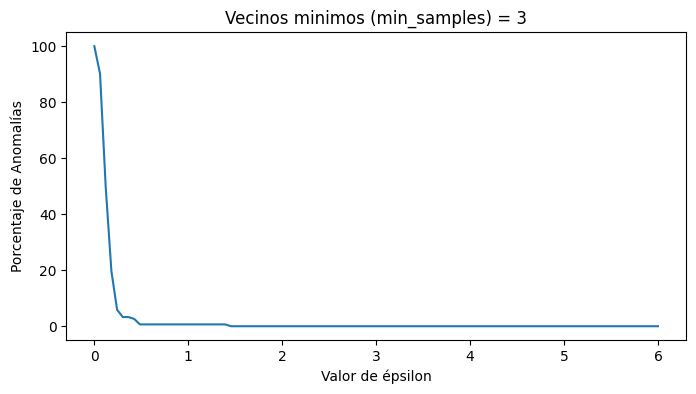

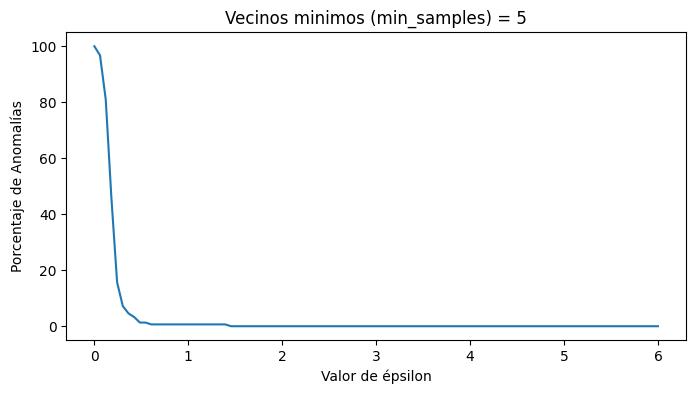

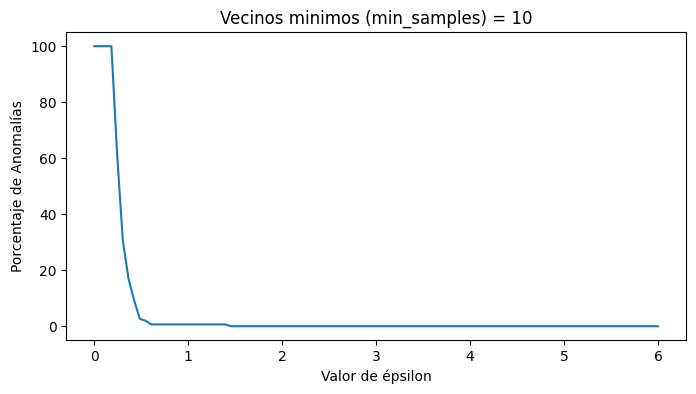

In [20]:
for min_samples in [3, 5, 10]:
    #Vamos a pintar ahora el porcentaje de anomalías vs el valor de eps probado
    plt.figure(figsize = (8, 4), dpi = 100)
    sns.lineplot(x = np.linspace(0.001, 6, 100), y = experiments[min_samples])
    plt.ylabel("Porcentaje de Anomalías")
    plt.xlabel("Valor de épsilon")
    plt.title(f"Vecinos minimos (min_samples) = {min_samples}")
    plt.show()

*Para eps = 0.5 aproximadamente los tres ejemplos caen en el número de anomalías. Probemos para ese rango cuántos clusteres nos salen*

In [21]:
for min_samples in [3, 5, 10]:
    dbscan = DBSCAN(eps = 0.5, min_samples = min_samples)
    dbscan.fit(train_set[features_short])
    print(f"Para {min_samples} de vecinos: {pd.Series(dbscan.labels_).nunique() - 1} clusters")

Para 3 de vecinos: 2 clusters
Para 5 de vecinos: 2 clusters
Para 10 de vecinos: 2 clusters


*Hmmm, mejor pero no está en el rango, para conseguir más clústeres hacemos como con todas las features, reducimos ligeramente eps, por ejemplo a 0.3*

In [22]:
for min_samples in [3, 5, 10]:
    dbscan = DBSCAN(eps = 0.3, min_samples = min_samples)
    dbscan.fit(train_set[features_short])
    print(f"Para {min_samples} de vecinos: {pd.Series(dbscan.labels_).nunique() - 1} clusters")

Para 3 de vecinos: 3 clusters
Para 5 de vecinos: 4 clusters
Para 10 de vecinos: 3 clusters


*Curiosamente con 5 vecinos se nos va a 4 clusteres, por tener 10 vecinos y 3 clusters, veamos el último ejemplo*

In [23]:
train_set_2f = train_set.copy()
train_set_2f["Cluster"] = dbscan.labels_

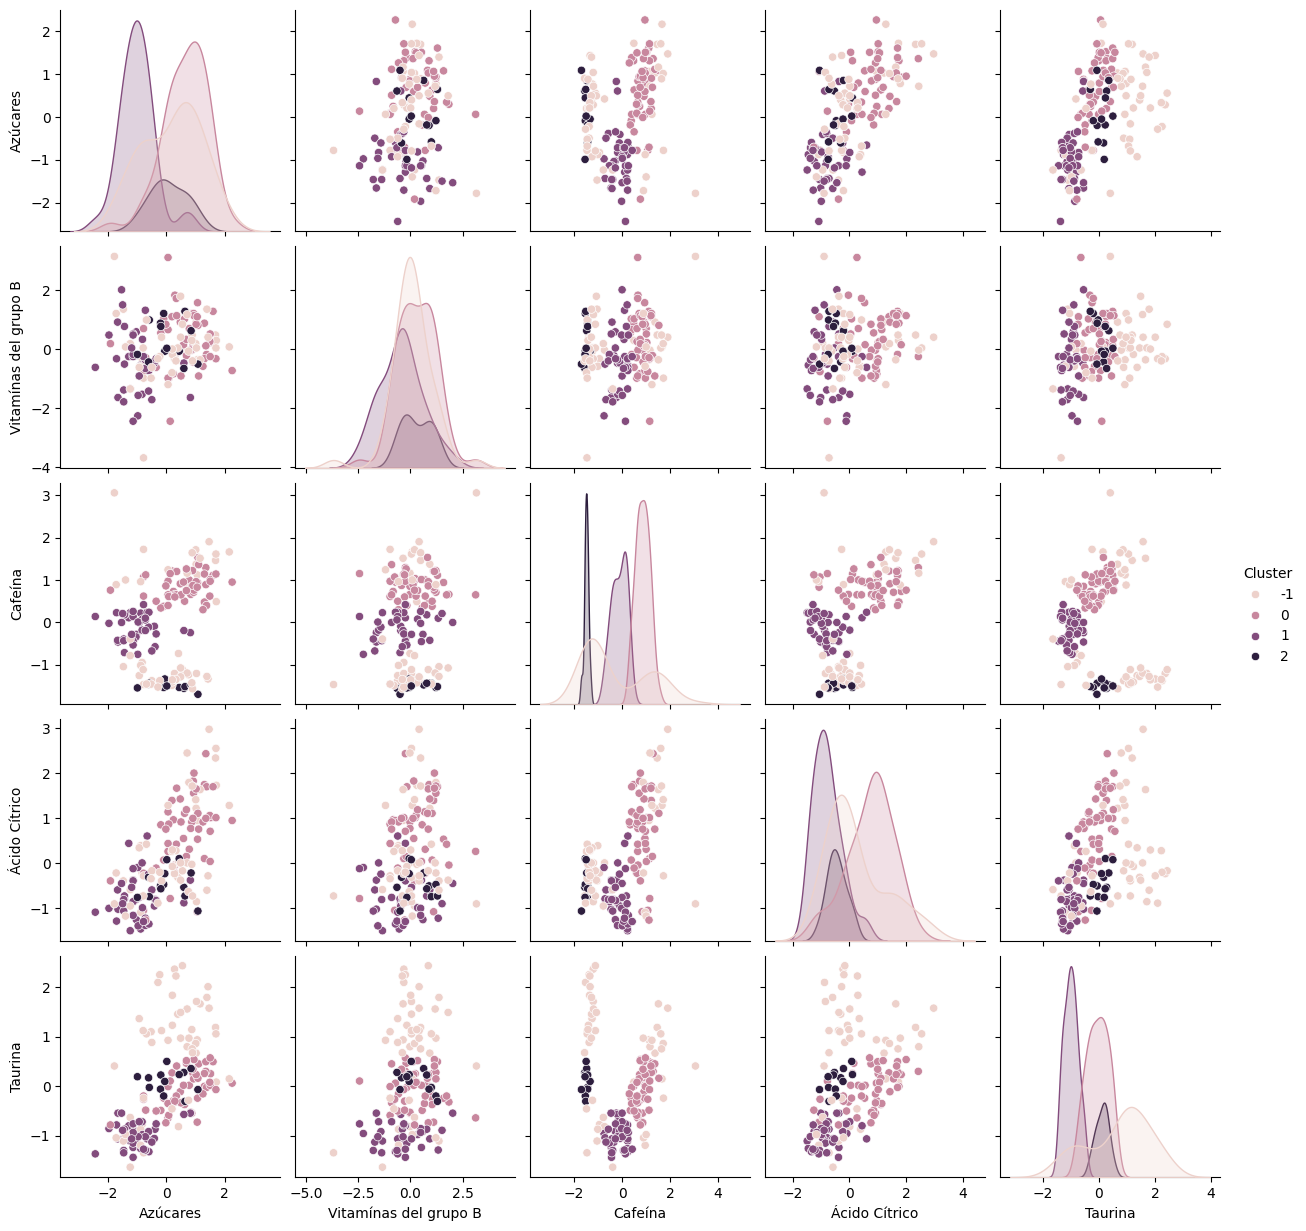

In [24]:
sns.pairplot(train_set_2f, hue = "Cluster")

*Demasiadas anomalías, al exigir 10 samples, probemos con 3*

In [25]:
train_set_2f = train_set.copy()
dbscan_3 = DBSCAN(eps = 0.3, min_samples = 3)
dbscan_3.fit(train_set[features_short])
train_set_2f["Cluster"] = dbscan_3.labels_

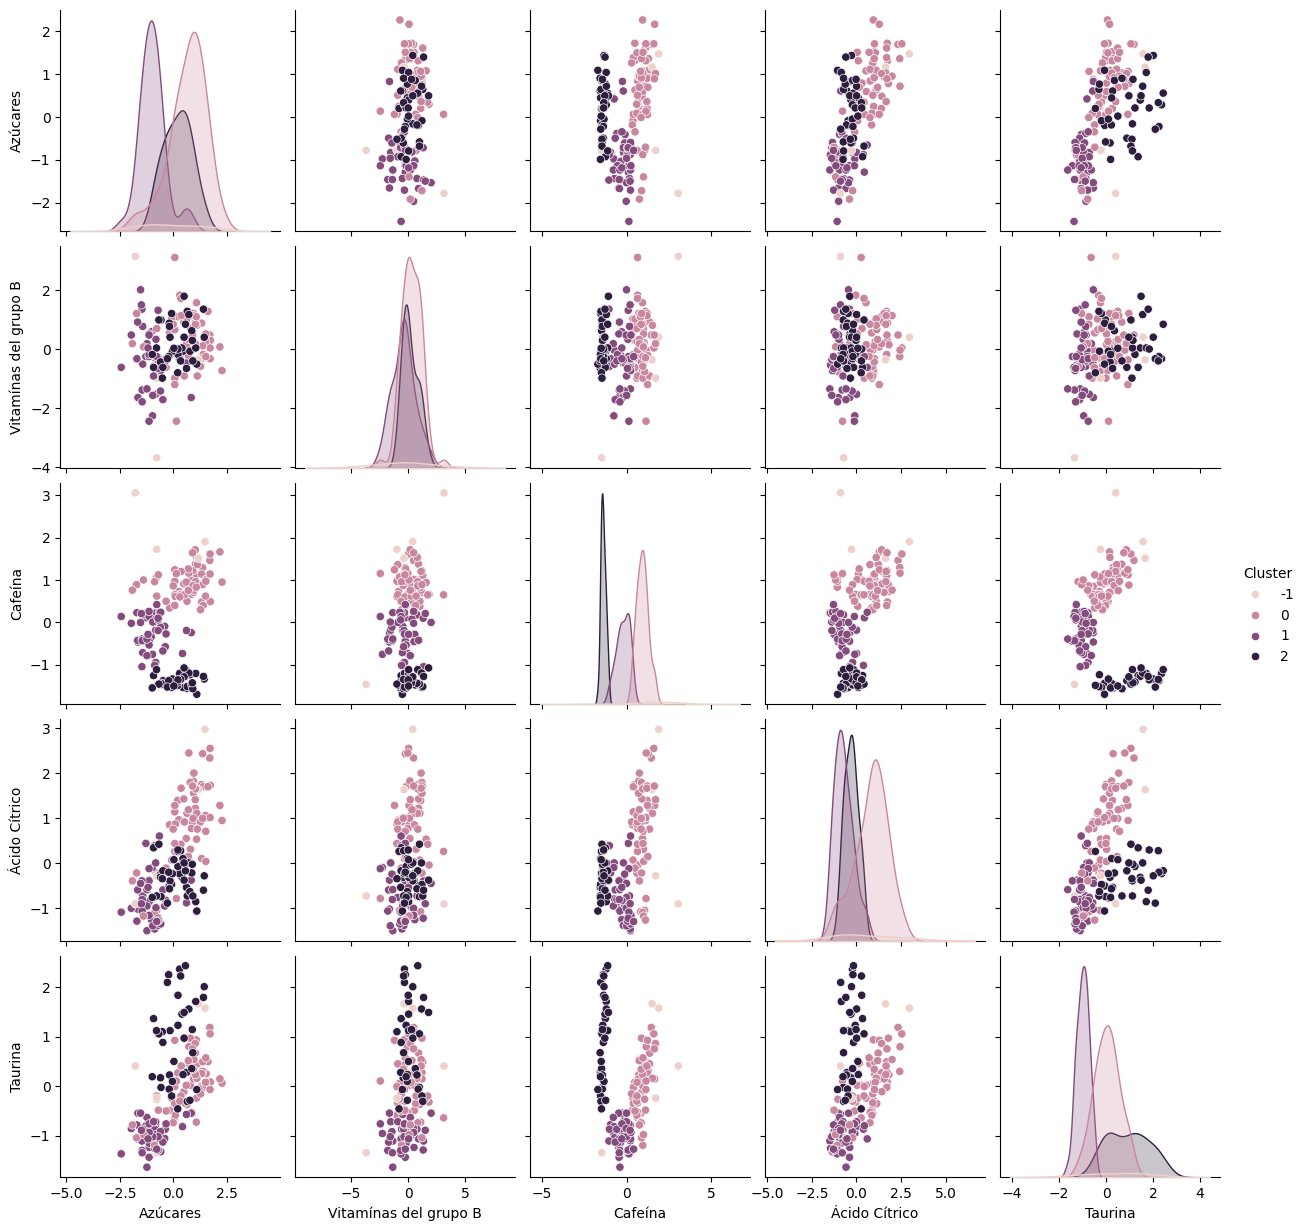

In [26]:
sns.pairplot(train_set_2f, hue = "Cluster")

<Axes: xlabel='Cafeína', ylabel='Taurina'>

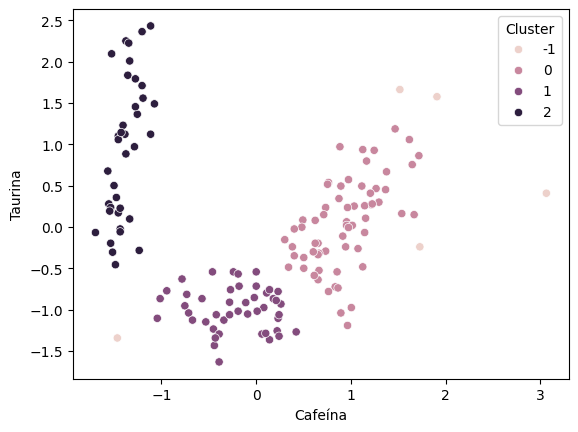

In [27]:
sns.scatterplot(data = train_set_2f, x = "Cafeína", y = "Taurina", hue = "Cluster")

*Fijándonos directamente en las agrupaciones que parecían funcionar para todas las features, es decir Cafeína-Taurina y Cafeína-Azucares, vemos que mejoran los clusters, además con menos anomalías. Por eso nos quedamos con eps = 0.3, min_samples = 3 y sólo dos features para el clustering DBSCAN ("Cafeína" y "Taurina")*

**JERARQUICO-AGLOMERATIVO**

*Lo primero para este caso es construirnos el dendrograma. Como no nos dicen nada usaremos el método de linkage ward y además con la experiencia del clustering anterior vamos a usar únicamente las dos features más características que dieron buen resultado (Cafeína y Taurina)*

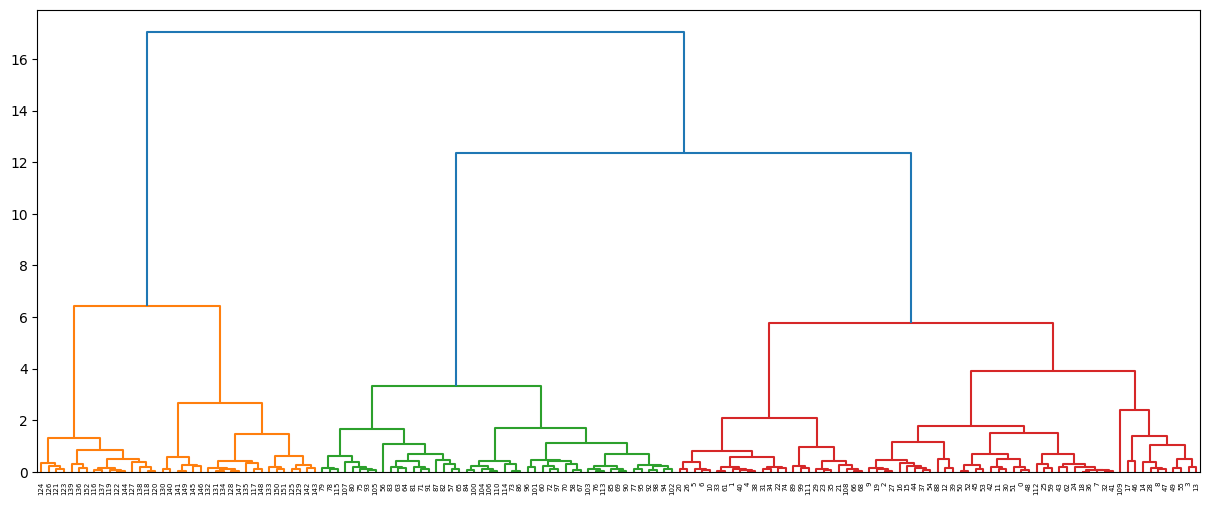

In [28]:
link_method = linkage(train_set[features_short], method = 'ward')
plt.figure(figsize = (15, 6))
dend = dendrogram(link_method)

*Como ya comentamos, la función dendrogram de scipy directamente nos aplica el método del máximo gap y puedes ver que nos marca tres clusteres directamente.*
*En cualquier caso, para que lo veamos más claramente superpongamos una linea vertical que aproveche el maximo gap horizontal, que está a una distancia superior a 7*

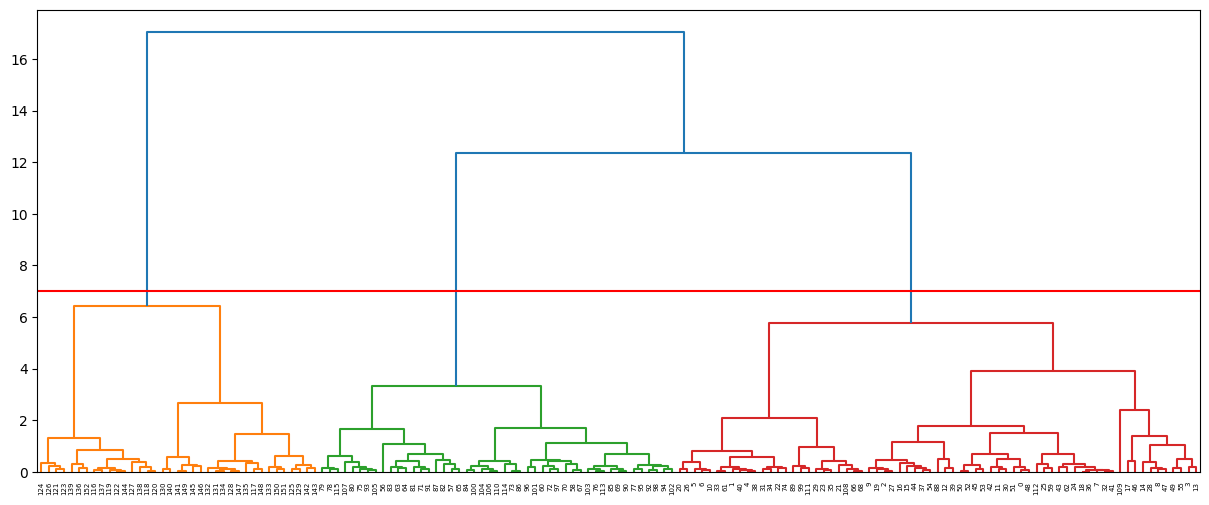

In [29]:
plt.figure(figsize = (15, 6))
dend = dendrogram(link_method)
plt.axhline(y = 7, color = 'r', linestyle = '-')

*Aplicamos el clustering aglomerativo y comprobemos qué tal queda el etiquetado comparándolo con DBSCAN anterior*

In [30]:
clustering_model = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
clustering_model.fit(train_set[features_short])
train_set_agg = train_set.copy()
train_set_agg['Cluster'] = clustering_model.labels_

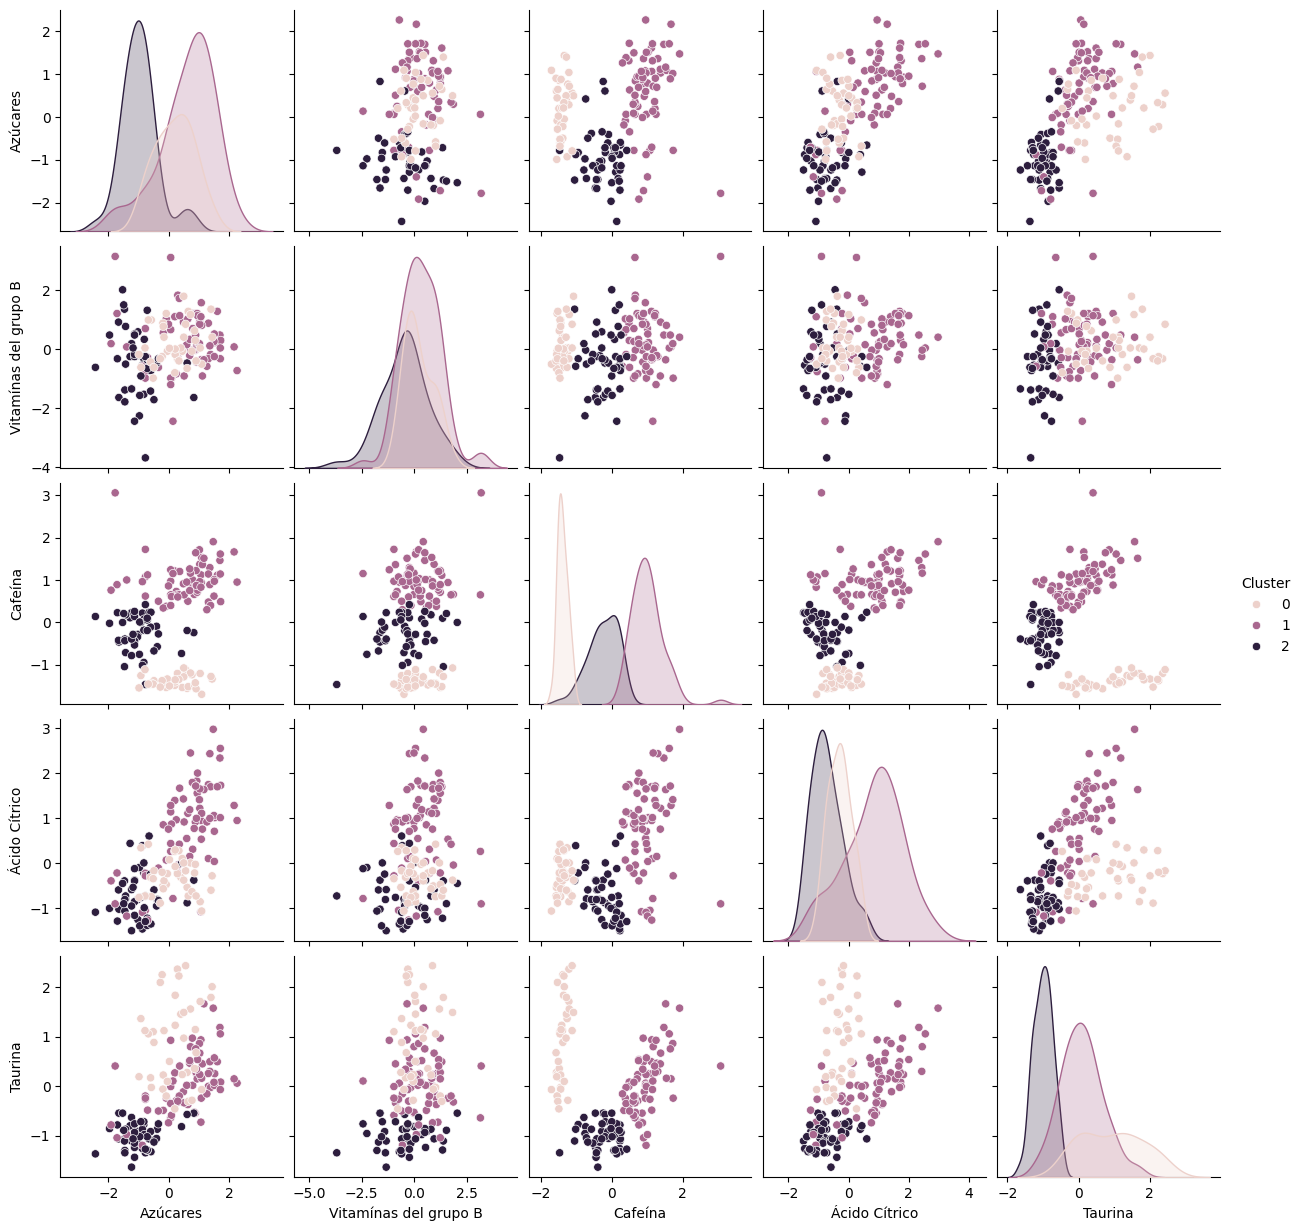

In [31]:
sns.pairplot(train_set_agg, hue = "Cluster")

*Fijándonos en las parejas que habíamos destacado en DBSCAN (Taurina-Cafeína y Cafeína Azucares) los clusteres son muy similares por no decir iguales, ya que les diferencian que DBSCAN establece la existencia de anomalías y el aglomarativo los ha incorporado a unos de los tres posibles clusteres*

*Por otro lado, podemos comprobar a qué color del dendrograma corresponde cada cluster y así además sabremos cómo de distantes están unos de otros para informar a los químicos y que estos valoren si tiene influencia en la energización de cada uno*

*Para la distancia entre clusteres:*    

*1. Método visual. Identificamos cada cluster a través de alguno de sus miembros:*

In [32]:
train_set_agg["Cluster"].value_counts()

Cluster
1    69
2    47
0    37
Name: count, dtype: int64

In [33]:
# Escogemos un indice (mira los números en la base del dendrograma), el 124 es el primero en el cluster naranja
train_set_agg.loc[124]

Azúcares                 0.765101
Vitamínas del grupo B   -0.060375
Cafeína                 -1.234146
Ácido Cítrico           -0.627005
Taurina                 -0.284670
Cluster                  0.000000
Name: 124, dtype: float64

*El cluster 0 es el cluster naranja*


In [34]:
print(f"Cluster naranja: {train_set_agg.loc[124]['Cluster']}")
print(f"Cluster verde: {train_set_agg.loc[79]['Cluster']}") # Cluster verde
print(f"Cluster rojo: {train_set_agg.loc[1]['Cluster']}")

Cluster naranja: 0.0
Cluster verde: 2.0
Cluster rojo: 1.0


*Y ahora vemos a "ojo" la distancia (la barra horizontal que los une):*
*Rojo y Verde (cluster 2 y 1) están a algo más de 12 de distancia y estos a más de 18 del cluster 0, aunque por la posición en el dendrograma el cluster verde está más cerca del naranja que el rojo*
*En este caso podríamos ordenar por 1,2,0 por ejemplo o a la inversa 0,2,1 los clusteres y serían los químicos los que nos deberían decir si esta ordenación (que te permite el clustering jerárquico) tiene un sentido real y aplicable o no*


*2. Usando el objeto link_method. Este objeto es una matriz con valores [idx1, idx2, dist, num_instancias] y están ordenadas, de manera que las últimas entradas corresponden a los últimos clustering.*

In [35]:
# Si te fijas en el dendrograma los tres clusters corresponden a los índices -5,-4,-3 (el antepenúltimo, el anterior y el anterior)
link_method[-5:-2]

array([[295.        , 297.        ,   3.91456299,  44.        ],
       [296.        , 300.        ,   5.7867262 ,  69.        ],
       [289.        , 298.        ,   6.42831329,  37.        ]])

In [36]:
train_set_agg["Cluster"].value_counts()

Cluster
1    69
2    47
0    37
Name: count, dtype: int64

In [37]:
link_method[-2:]

array([[299.        , 301.        ,  12.34117438, 116.        ],
       [302.        , 303.        ,  17.05969203, 153.        ]])

*Aunque poco elegante porque hay que recurrir al numero de elementos para identificarlos, observa que la distancia entre 1 y 2 es de 12.34 y entre estos y el 0 de 17.05.*

*La comparación es especulativa porque no tenemos target para confirmar nada*


### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [38]:
X_new = pd.read_csv("./data/new_experiments.csv", sep = "|")

In [39]:
X_new

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina
0  1.481555               0.305159  1.366128       2.239039  0.731870
1  0.616869               0.890014  0.583034       0.312420 -0.665332
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583
5  0.962743              -0.243142 -1.354622      -0.420013  1.956043

**Jerárquico**

*El problema con los jerárquicos es que debemos reconstruir todo el cluster con el problema que puede suponer (volvemos a reetiquetar), aunque también podemos acudir al método de utilizar el primer dataset ya etiquetado y entrenar un modelo sobre él*

In [40]:
new_train_set = pd.concat([train_set, X_new])

*Probamos con los anteriores valores de hiperparámetros, aunque pudiera ser necesario obtener unos nuevos*

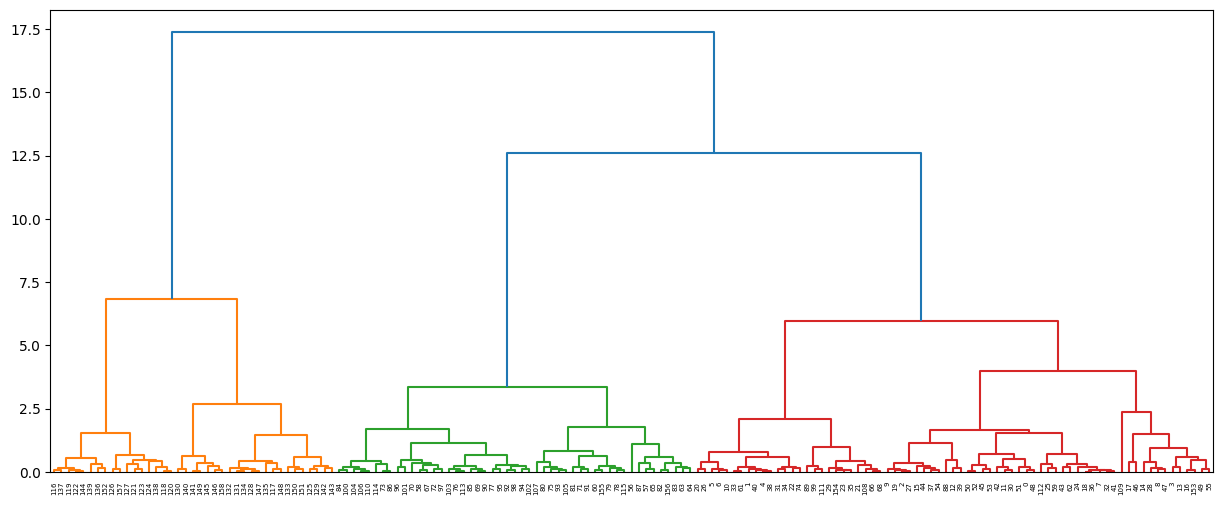

In [41]:
link_method = linkage(new_train_set[features_short], method = 'ward')
plt.figure(figsize = (15, 6))
dend = dendrogram(link_method)

*Nada parace haber cambiado, obtengamos el cluster y las etiquetas asignadas a los nuevos experimentos*

In [42]:
clustering_model = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
clustering_model.fit(new_train_set[features_short])
new_train_set_agg = new_train_set.copy()
new_train_set_agg['Cluster'] = clustering_model.labels_

In [43]:
new_train_set_agg.tail(len(X_new))

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina  Cluster
0  1.481555               0.305159  1.366128       2.239039  0.731870        1
1  0.616869               0.890014  0.583034       0.312420 -0.665332        1
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782        2
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240        2
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583        0
5  0.962743              -0.243142 -1.354622      -0.420013  1.956043        0

**DBSCAN**

*Con la aproximación DBSCAN podríamos hacer igual que con el jerárquico, volver a modelar, pero lo que vimos es que normalmente se procede obteniendo un modelo de clasificación a partir del dataset inicial ya etiquetado y eso vamos a hacer. Aprovechando el escalado y como repetición de lo visto en el workout vamos a utilizar un KNN, optimizando el hiperparámetro k*

In [44]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
target = "Cluster"
X_train = train_set_2f.drop(target, axis = 1) # No uso dataset de test, porque no lo necesito, optimizare con cross_val y predeciremos contra X_new
y_train = train_set_2f[target]

In [45]:
param_grid = {
    "n_neighbors": [2, 3, 5, 10],
    "weights": ["uniform", "distance"]
}

knn_grid = GridSearchCV(knn,
                        param_grid = param_grid,
                        cv = 4, # un "train-test" split un poco mayor del 20%
                        scoring = "balanced_accuracy" # Multiclase en el que todos son importantes
                        )

knn_grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 5, 10],
                         'weights': ['uniform', 'distance']},
             scoring='balanced_accuracy')

In [46]:
knn_grid.best_params_

{'n_neighbors': 2, 'weights': 'uniform'}

In [47]:
knn_grid.best_score_

0.7747395833333334

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_train, knn_grid.best_estimator_.predict(X_train)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         5
           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00        46
           2       1.00      1.00      1.00        37

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153



*Ha logrado copiar el clusteing :-) con un buen overfitting, lo cual era importante porque nuestro train en realidad es nuestra población, asignemos ahora a las nuevas instancias*

In [49]:
y_pred = knn_grid.best_estimator_.predict(X_new)

In [50]:
X_new["Cluster"] = y_pred

In [51]:
X_new

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina  Cluster
0  1.481555               0.305159  1.366128       2.239039  0.731870        0
1  0.616869               0.890014  0.583034       0.312420 -0.665332        0
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782        1
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240        1
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583        2
5  0.962743              -0.243142 -1.354622      -0.420013  1.956043        2

*Comprobemos que son las mismas asignaciones que con el jerárquico aunque con el nombre de las etiquetas cambiado*

In [52]:
train_set_2f.head()

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina  Cluster
0  1.518613               0.232053  1.034819       1.013009  0.251717        0
1  0.246290              -0.827996  0.733629       0.965242 -0.293321        0
2  0.196879               1.109334  1.215533       1.395148  0.269020        0
3  1.691550               0.487926  1.466525       2.334574  1.186068        0
4  0.295700               1.840403  0.663351      -0.037874 -0.319276        0

In [53]:
new_train_set_agg.head()

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina  Cluster
0  1.518613               0.232053  1.034819       1.013009  0.251717        1
1  0.246290              -0.827996  0.733629       0.965242 -0.293321        1
2  0.196879               1.109334  1.215533       1.395148  0.269020        1
3  1.691550               0.487926  1.466525       2.334574  1.186068        1
4  0.295700               1.840403  0.663351      -0.037874 -0.319276        1

In [53]:
train_set_2f.merge(new_train_set_agg, left_index = True, right_index = True, suffixes = ["_DBSCAN", "_Agglo"])[["Cluster_DBSCAN", "Cluster_Agglo"]].value_counts()

Cluster_DBSCAN  Cluster_Agglo
 0              1                67
 1              2                46
 2              0                37
-1              1                 4
 0              0                 2
                2                 2
-1              2                 1
Name: count, dtype: int64

*Quitando las anomalias de DBSCAN y algunos puntos de no coincidencia en los clusteres: la clase 0 de DBSCAN corresponde a la 1 de Agglo, la 1 a la 2 y la 2 a la 0*

*Han hecho la misma clasificación de los nuevos. Bien, poco más podríamos decir y hacer salvo pasarle nuestros resultados a "Negocio" en este caso los químicos...*

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionaste e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalúa la segmentación de los modelos creados en la primera parte.

*Perfecto, targets, targets, targets... Creemos un único dataset para DBSCAN y hagamos nuestros clasification reports*

In [54]:
df_results = pd.read_csv("./data/power_results.csv", sep = "|")
df_results

class
0        1
1        1
2        1
3        1
4        1
..     ...
154      1
155      2
156      2
157      3
158      3

[159 rows x 1 columns]

In [55]:
y_test = df_results["class"] - 1 # para ser 0, 1, 2

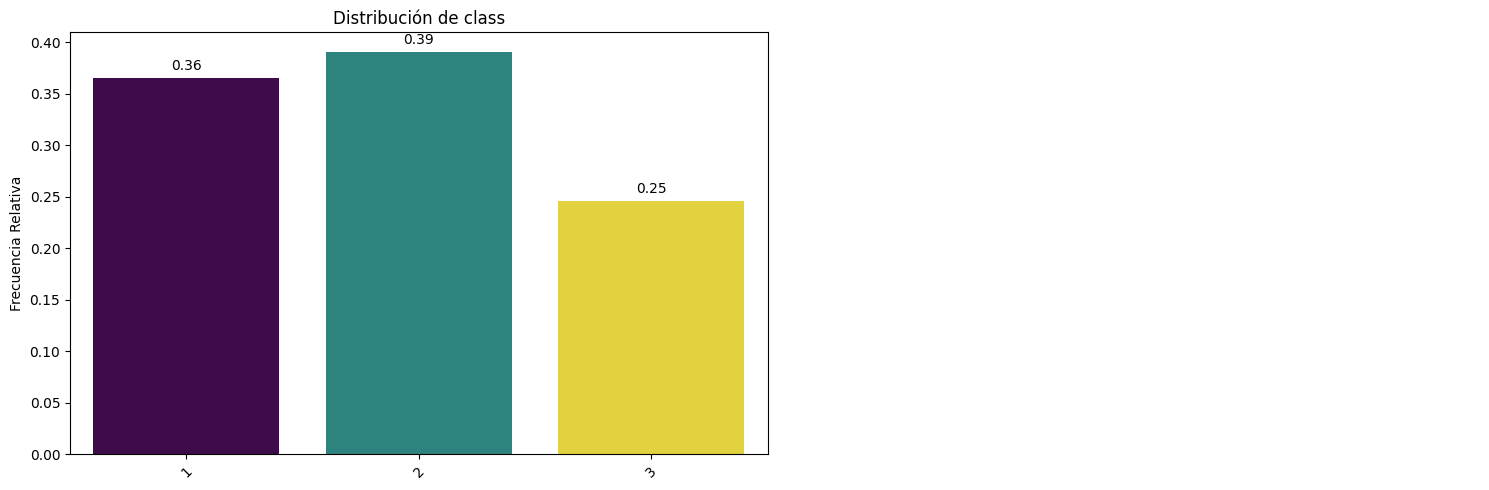

In [56]:
bt.pinta_distribucion_categoricas(df_results, ["class"], mostrar_valores = True, relativa = True)

**DBSCAN**

In [57]:
full_train_set_2f = pd.concat([train_set_2f, X_new]) # añadimos el target, ahora lo conocemos
y_pred = full_train_set_2f["Cluster"]

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.84      0.97      0.90        58
           1       1.00      0.77      0.87        62
           2       1.00      1.00      1.00        39

    accuracy                           0.90       159
   macro avg       0.71      0.68      0.69       159
weighted avg       0.94      0.90      0.91       159



c:\Users\noemo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\noemo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\noemo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

*Como tenemos las anomalías deberíamos quitarlas*

In [59]:
full_train_set_2f["true_class"] = y_test

In [60]:
y_test_dbscan = full_train_set_2f[full_train_set_2f.Cluster != -1]["true_class"]
y_pred_dbscan = full_train_set_2f[full_train_set_2f.Cluster != -1]["Cluster"]

In [61]:
print(classification_report(y_test_dbscan,y_pred_dbscan))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        60
           1       0.96      0.81      0.88        57
           2       0.95      1.00      0.97        37

    accuracy                           0.90       154
   macro avg       0.91      0.91      0.91       154
weighted avg       0.91      0.90      0.90       154



*Magnifico, hmmm vale, estaba un poco preparado...*

**Jerárquico**

In [62]:
y_pred = new_train_set_agg["Cluster"]
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.18      0.21      0.20        62
           2       0.00      0.00      0.00        39

    accuracy                           0.08       159
   macro avg       0.06      0.07      0.07       159
weighted avg       0.07      0.08      0.08       159



*Muy mal, porque tenemos que hacer la "traducción" de etiquetas*

In [63]:
map_clusters = {
    1: 0,
    2: 1,
    0: 2
}
y_pred = new_train_set_agg["Cluster"].map(map_clusters)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        58
           1       1.00      0.79      0.88        62
           2       1.00      1.00      1.00        39

    accuracy                           0.92       159
   macro avg       0.94      0.93      0.93       159
weighted avg       0.93      0.92      0.92       159



*Son muy parecidos pero el jerárquico ha "cazado" los outliers a costa de perder algunas clases 1. Ahora, 6 meses después podríamos quedarnos con uno u otro pero mientras cualquiera de los dos hubiera valido perfectamente. Eso sí, solo el jerárquico nos proporciona ese valor de distancia entre clases*

In [65]:
# modelo.fit_predict(X, y) -> modelo.fit(X, y) y  luego modelo.predict(X)
# clases SKlearn -> estimator/transformer -> fit, predict, fit_predict -> fit_transform